C:\Users\Armin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


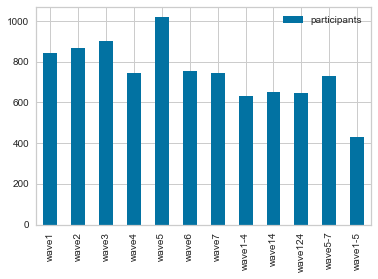

In [1]:
#Steps 5-7

import numpy as np
import pandas as pd
import pandas_profiling as pp
from IPython.display import display, HTML
import pymannkendall as mk
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import KFold, cross_val_score
from itertools import combinations
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import ipynb.fs.full.script
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from statsmodels.sandbox.regression.predstd import wls_prediction_std


%matplotlib inline
pd.options.display.max_columns = None

pd.options.display.max_rows = 10
pd.options.display.width = 200
np.set_printoptions(precision = 4, suppress = True) 

legit_classes1 = [67,71,72,74,77,78,79,81,83,86,100,101,103,121,122,125,126,127,129,130,131,133,135,138]
legit_classes2 = [73,74,78,81,82,86,100,103,124,125,131,133,135,141,250,251,256,258,259,261,262,263,272,273,277,279,290,291,292,296,297,298,299,300,301,302,303,304,305,306,307,308,310]
participants = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/8. Metadata/Participant_Info.csv", sep= ';')

par_w1 = participants["W1"] == 1
par_w2 = participants["W2"] == 1
par_w3 = participants["W3"] == 1
par_w4 = participants["W4"] == 1
par_w5 = participants["W5"] == 1
par_w6 = participants["W6"] == 1
par_w7 = participants["W7"] == 1

total1 = len(participants[par_w1])
total2 = len(participants[par_w3])
total3 = len(participants[par_w2])
total4 = len(participants[par_w4])
total5 = len(participants[par_w5])
total6 = len(participants[par_w6])
total7 = len(participants[par_w7])
total1_4 = len(participants[par_w1 & par_w2 & par_w3 & par_w4])
total14 = len(participants[par_w1 & par_w4])
total124 = len(participants[par_w1 & par_w2 & par_w4])
total5_7 = len(participants[par_w5 & par_w6 & par_w7])
total1_5 = len(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5])

par_per_wave = pd.DataFrame({
    'participants': [total1, total2, total3, total4, total5, total6, total7, total1_4, total14, total124, total5_7, total1_5]}, index=['wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'wave6', 'wave7', 'wave1-4', 'wave14','wave124', 'wave5-7', 'wave1-5'])

par_per_wave.plot.bar()


#display(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5 & par_w6 & par_w7])
#print(participants[par_w1 & par_w2 & par_w3 & par_w4].count)

In [2]:
#getting participants from 5 to 7
participants5_7 = participants[['Child','Class_Y3']][par_w5 & par_w6 & par_w7]
participants5_7 = participants5_7[participants5_7["Class_Y3"].isin(legit_classes2)]
par_57 = participants5_7
participants5_7 = participants5_7["Child"].tolist()
schools = participants['School'][participants['Child'].isin(participants5_7)].unique().tolist()
display(schools)

[26, 29, 28, 30, 32, 33, 34, 38, 39, 40, 43, 54, 55, 42, 56, 57, 58, 59, 60]

In [3]:
#fit
#compare waves with eachother as percentage for example
fit_clean = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/5. Fitbit data/Fitbit_W17_cleaned_imputation.csv", sep= ';')
fit_clean5_7 = fit_clean[fit_clean["Child"].isin(participants5_7)]

fit_clean5_7 = fit_clean5_7[fit_clean5_7["Wave"] <= 3]

fit_clean5_7 = fit_clean5_7.drop(columns = ['Imputed','Participated'])
fit_clean5_7 = fit_clean5_7.sort_values(['Child','Wave', 'Day'])
display(fit_clean5_7[fit_clean5_7['Child'] == 1222])

,School,Class,Child,Sex,Age,Wave,Day,Date,Steps,Minutes_MVPA


In [4]:
# get the average amount of steps per child over wave 5-7
avg_Steps_57 = fit_clean5_7[['School', 'Class', 'Child', 'Wave','Day','Steps']].copy()
avg_Steps_57 = avg_Steps_57.groupby('Child').mean()
avg_Steps_57 = avg_Steps_57.drop(columns = ['Wave', 'Day', 'Class', 'School'])
avg_Steps_57.reset_index()

full_table_57 = avg_Steps_57
full_table_57 = full_table_57.reset_index()
temp = fit_clean5_7.drop(columns = ['Minutes_MVPA', 'Date', 'Steps', 'Day', 'Wave'])
temp = temp.drop_duplicates(subset = ["Child"])

full_table_57 = full_table_57.merge(temp)
full_table_57

,Child,Steps,School,Class,Sex,Age
0,1414,8578.900000,26,74,0,9.0
1,1420,14617.727273,26,74,0,10.0
2,1421,10334.071429,26,74,1,10.0
3,1422,7011.444444,26,74,0,9.0
4,1423,6403.100000,26,74,0,11.0
...,...,...,...,...,...,...
209,4889,15484.777778,40,131,1,9.0
210,4890,12228.888889,40,131,1,9.0
211,6135,NaN,40,131,1,9.0
212,6137,NaN,40,131,1,9.0


In [5]:
#socio
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')

socio_lcl_567 = socio_lcl_567.rename(columns={"Node": "Child"})
socio_lcl_567 = socio_lcl_567.drop(['Unnamed: 0', 'ClusteringC'], axis = 1)
socio_gbl_567 = socio_gbl_567.drop(['Unnamed: 0'], axis = 1)

#Add socio data to the full table of week 5-7
full_table_57 = full_table_57.merge(socio_lcl_567, how = 'left')
full_table_57 = full_table_57.merge(socio_gbl_567, how = 'left')
display(full_table_57)
children = full_table_57['Child']

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes
0,1414,8578.900000,26,74,0,9.0,0.001515,0.592593,1.000000,0.277652,0.814103,0.570513,89.0,13.0
1,1420,14617.727273,26,74,0,10.0,0.024387,0.592593,1.583333,0.277652,0.814103,0.570513,89.0,13.0
2,1421,10334.071429,26,74,1,10.0,0.005195,0.592593,1.083333,0.277652,0.814103,0.570513,89.0,13.0
3,1422,7011.444444,26,74,0,9.0,0.024387,0.592593,1.583333,0.277652,0.814103,0.570513,89.0,13.0
4,1423,6403.100000,26,74,0,11.0,0.013763,0.533333,1.333333,0.245043,0.814103,0.570513,89.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,4889,15484.777778,40,131,1,9.0,0.016560,0.689655,0.900000,0.291802,1.702381,0.438095,184.0,21.0
210,4890,12228.888889,40,131,1,9.0,0.010701,0.666667,0.800000,0.253143,1.702381,0.438095,184.0,21.0
211,6135,NaN,40,131,1,9.0,0.029877,0.666667,1.000000,0.282171,1.702381,0.438095,184.0,21.0
212,6137,NaN,40,131,1,9.0,0.054766,0.606061,1.050000,0.211072,1.702381,0.438095,184.0,21.0


In [6]:
#questionnaire 
questionnaire_5 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W1_Main_questions.csv", sep= ';')
questionnaire_6 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W2_Main_questions.csv", sep= ';')
questionnaire_7 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W3_Main_questions.csv", sep= ';')
questionnaire_567 = questionnaire_5.merge(questionnaire_6, on = 'Child')
questionnaire_567 = questionnaire_567.merge(questionnaire_7, on = 'Child')
#display(questionnaire_123.filter(regex=("ME_Internet_Game_Exposure_ME_SM.*")))

questionnaire_567 = questionnaire_567[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x','PA_motivation_PA_motiv_.extrin1_x', 
                                       'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']]
temp = questionnaire_6.loc[:, questionnaire_6.columns.str.contains('facili')]
temp['Child'] = ""
temp = questionnaire_6[temp.columns]
temp = temp.set_index('Child')

# Give a 0 or 1 value for each facility wether it is or is not in the enviroment of the child
for index, row in temp.iterrows():
    temp.loc[index,'Bos'] = row.str.contains('Bos').any()
    temp.loc[index,'Park'] = row.str.contains('Park').any()
    temp.loc[index,'Speelplein'] = row.str.contains('Speelplein').any()
    temp.loc[index,'Speeltuin'] = row.str.contains('Speeltuin').any()
    temp.loc[index,'Sportschool'] = row.str.contains('Sportschool').any()
    temp.loc[index,'Sportclub'] = row.str.contains('Sportclub').any()
    temp.loc[index,'Zwembad'] = row.str.contains('Zwembad').any()
    temp.loc[index,'Meer_zee'] = row.str.contains('Meer_zee').any()
    temp.loc[index,'Dansschool'] = row.str.contains('Dansschool').any()
    temp.loc[index,'Sporthal'] = row.str.contains('Sporthal').any()
    temp.loc[index,'Grasveld'] = row.str.contains('Grasveld').any()
    
temp.drop(temp.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]],axis=1,inplace=True)
temp = temp.astype(int)
questionnaire_567 = questionnaire_567[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x','PA_motivation_PA_motiv_.intrin2_x', 
                                       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 
                                       'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']].dropna()
questionnaire_567 = questionnaire_567.loc[questionnaire_567['Child'].isin(children)]
questionnaire_567.drop_duplicates()


C:\Users\Armin\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Child,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1814,1.0,5.0,4.0,1.0,6.0,2.0,1.0
1,1815,7.0,6.0,1.0,1.0,6.0,4.0,2.0
2,1819,1.0,6.0,4.0,1.0,6.0,3.0,6.0
6,1428,4.0,6.0,1.0,1.0,5.0,3.0,1.0
13,1606,5.0,6.0,1.0,1.0,6.0,3.0,1.0
...,...,...,...,...,...,...,...,...
313,1429,7.0,6.0,1.0,1.0,6.0,3.0,6.0
359,1817,7.0,6.0,6.0,6.0,6.0,3.0,1.0
390,2902,5.0,3.0,3.0,5.0,4.0,5.0,5.0
414,3183,7.0,6.0,1.0,1.0,4.0,5.0,1.0


In [7]:
temp = temp.reset_index()
full_table_57 = full_table_57.merge(temp)

# merge with the barrier question
temp = questionnaire_567
full_table_57 = full_table_57.merge(temp)
display(full_table_57)
full_table_57 = full_table_57.dropna()

full_table_57['PA_Barriers_Resource_place_1'] = full_table_57['PA_Barriers_Resource_place_1'].fillna(method = 'ffill')
display(full_table_57['Age'].value_counts())


,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1428,7960.333333,26,74,1,9.0,0.035877,0.533333,1.500000,0.239914,0.814103,0.570513,89.0,13.0,0,1,0,1,0,0,0,1,1,0,1,4.0,6.0,1.0,1.0,5.0,3.0,1.0
1,1429,13182.846154,26,74,1,11.0,0.000000,0.750000,0.750000,0.365000,0.814103,0.570513,89.0,13.0,0,0,1,1,1,1,1,1,1,1,1,7.0,6.0,1.0,1.0,6.0,3.0,6.0
2,1605,5356.000000,29,81,1,12.0,0.035351,0.729730,1.629630,0.187245,1.361111,0.638889,483.0,28.0,0,0,0,1,0,0,1,0,0,0,0,4.0,6.0,2.0,6.0,6.0,3.0,1.0
3,1606,7386.454545,29,81,1,9.0,0.017900,0.870968,1.518519,0.240861,1.361111,0.638889,483.0,28.0,0,1,1,1,1,1,1,0,1,1,1,5.0,6.0,1.0,1.0,6.0,3.0,1.0
4,1608,10115.538462,29,81,1,10.0,0.040500,0.818182,1.777778,0.219043,1.361111,0.638889,483.0,28.0,1,0,1,1,1,1,1,0,1,1,1,2.0,6.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3202,13575.428571,43,141,1,10.0,0.023271,0.601604,1.235294,0.203127,1.212418,0.565359,173.0,18.0,0,0,1,1,0,0,0,0,0,0,1,4.0,5.0,1.0,2.0,5.0,3.0,2.0
148,3203,13161.214286,43,141,1,10.0,0.041356,0.661765,1.529412,0.233438,1.212418,0.565359,173.0,18.0,0,0,1,1,1,1,0,0,1,1,1,7.0,6.0,1.0,1.0,6.0,4.0,1.0
149,3205,7536.166667,43,141,0,9.0,0.009506,0.630252,0.941176,0.222933,1.212418,0.565359,173.0,18.0,0,1,0,1,0,0,1,0,0,0,0,7.0,6.0,1.0,1.0,6.0,4.0,2.0
150,3215,10056.615385,43,141,1,9.0,0.030782,0.696594,1.411765,0.254826,1.212418,0.565359,173.0,18.0,0,0,0,1,0,0,0,0,0,1,1,7.0,6.0,5.0,1.0,6.0,6.0,1.0


9.0     92
10.0    51
11.0     4
12.0     1
Name: Age, dtype: int64

In [8]:
full_table_57.columns
pd.set_option('display.max_rows', None)
display(full_table_57.corr() ['Steps'])
pd.set_option('display.max_rows', 10)

Child                                       0.357620
Steps                                       1.000000
School                                      0.337577
Class                                       0.350558
Sex                                        -0.218193
Age                                        -0.028669
Betweeness                                  0.113105
Closeness                                   0.030767
Degree                                      0.090168
Eigenvector                                 0.148512
Avg_Short_Path                             -0.060943
Density                                     0.029574
Edges                                      -0.218184
Nodes                                      -0.202864
Bos                                         0.151564
Park                                       -0.001530
Speelplein                                  0.185978
Speeltuin                                  -0.016004
Sportschool                                 0.

In [9]:
full_table_57.describe()

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,2423.662162,10699.759796,34.885135,107.885135,0.533784,9.418919,0.022452,0.697387,1.268977,0.213008,1.301821,0.602463,270.864865,21.310811,0.243243,0.418919,0.628378,0.831081,0.310811,0.459459,0.351351,0.175676,0.250000,0.364865,0.797297,4.993243,5.236486,1.472973,1.520270,5.601351,3.486486,1.837838
std,676.822222,3134.480814,5.276728,24.316374,0.500551,0.583369,0.027559,0.109882,0.349426,0.057007,0.188601,0.110919,125.536923,4.870921,0.430498,0.495057,0.484879,0.375953,0.464397,0.500046,0.479014,0.381836,0.434483,0.483027,0.403378,2.208507,1.263628,1.290710,1.220402,0.994816,1.643319,1.493997
min,1428.000000,4724.900000,26.000000,74.000000,0.000000,9.000000,0.000000,0.377358,0.500000,0.044807,0.814103,0.415789,89.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1647.250000,8186.634615,29.000000,81.000000,0.000000,9.000000,0.005738,0.634836,1.000000,0.179696,1.212418,0.492611,173.000000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000,1.000000,1.000000,6.000000,2.000000,1.000000
50%,2348.500000,10335.227273,34.000000,103.000000,1.000000,9.000000,0.013595,0.704167,1.235294,0.224316,1.271053,0.636029,267.000000,20.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,3.000000,1.000000
75%,3155.250000,13153.380495,40.000000,131.500000,1.000000,10.000000,0.027708,0.764286,1.562500,0.246146,1.363971,0.691176,400.000000,28.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.250000,1.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,4.000000,2.000000
max,3218.000000,19267.846154,43.000000,141.000000,1.000000,12.000000,0.151599,0.947368,1.944444,0.365000,1.702381,0.780702,483.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,6.000000,6.000000,6.000000,6.000000,9.000000,6.000000


C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


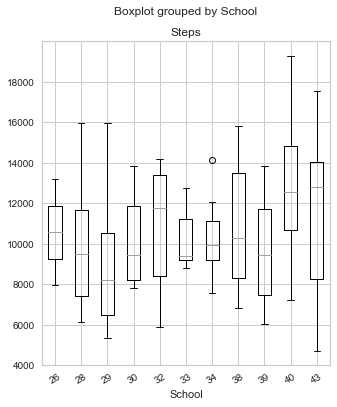

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


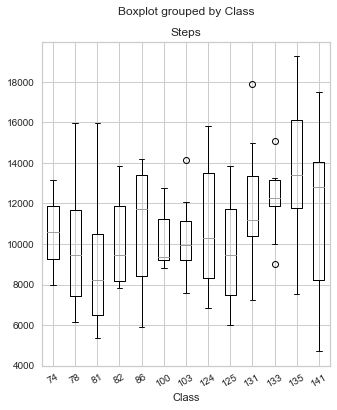

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


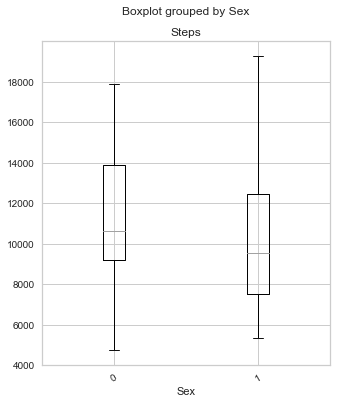

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


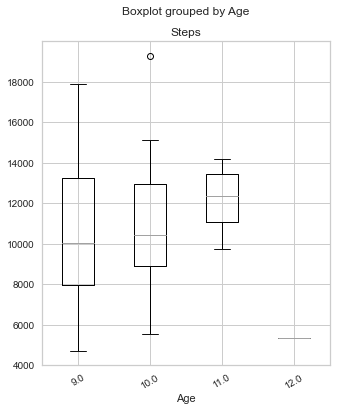

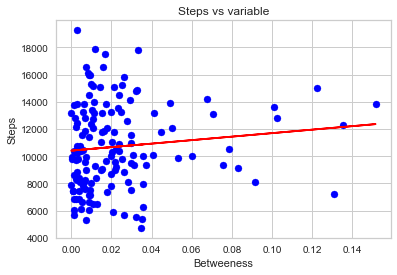

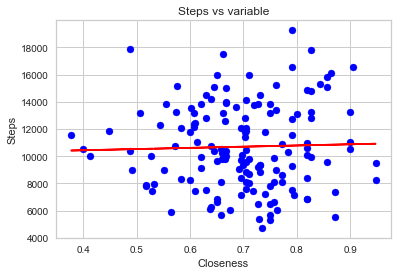

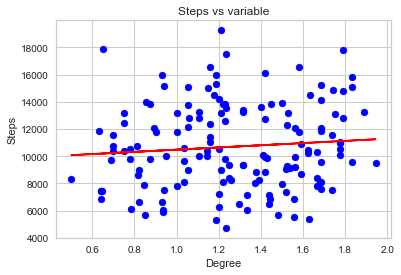

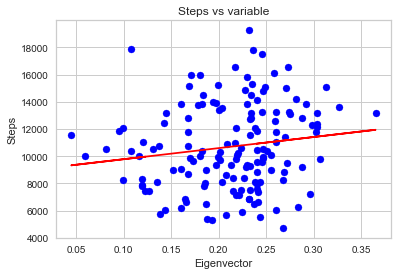

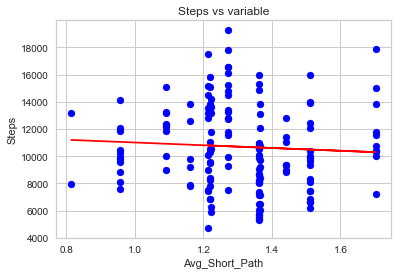

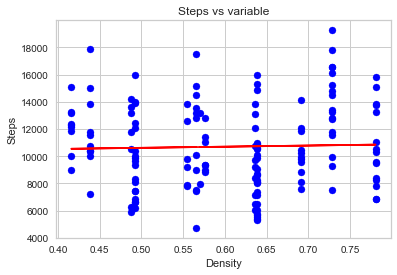

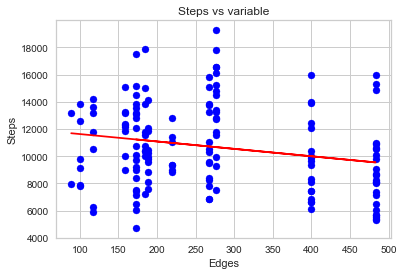

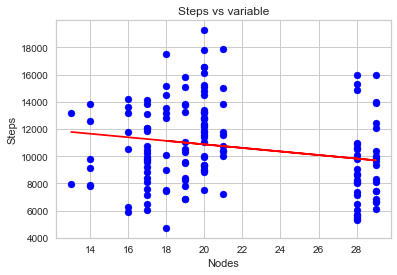

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


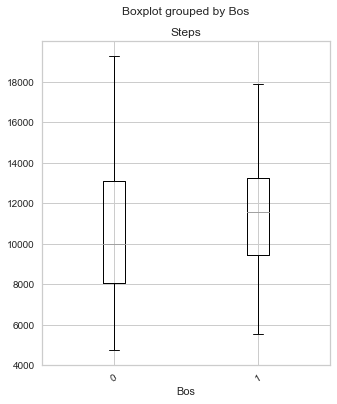

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


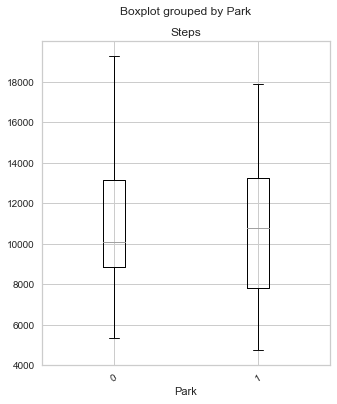

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


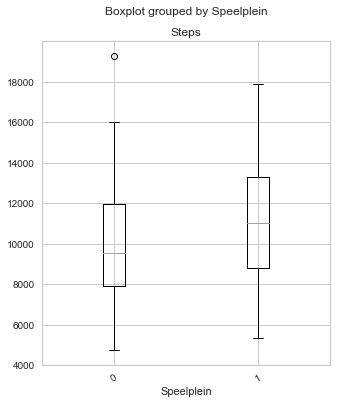

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


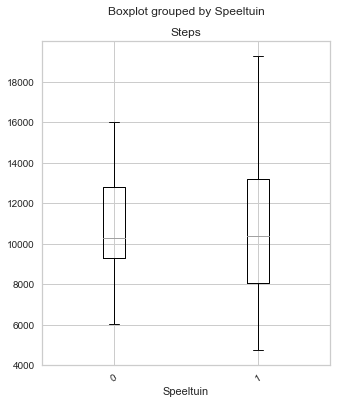

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


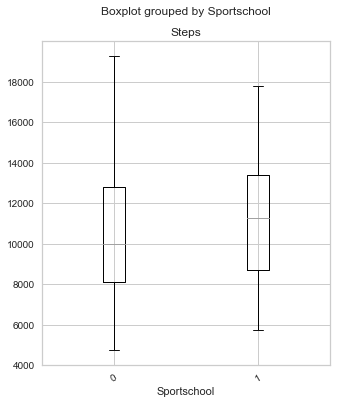

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


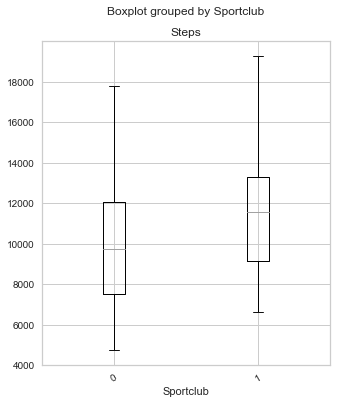

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


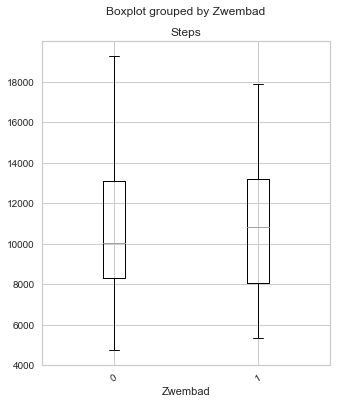

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


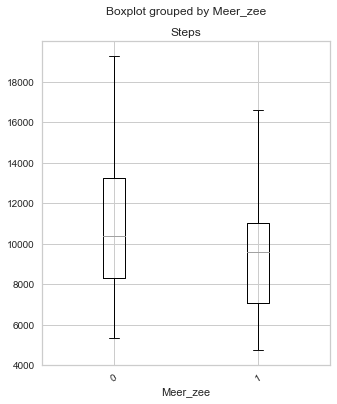

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


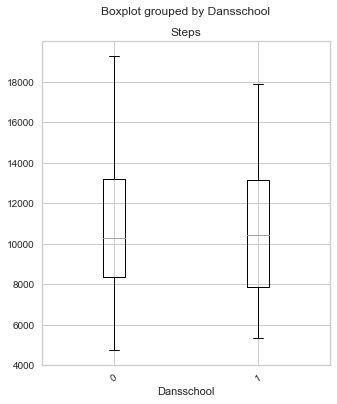

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


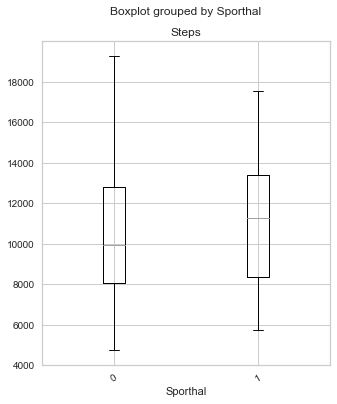

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


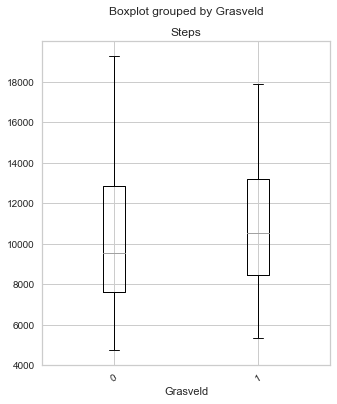

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


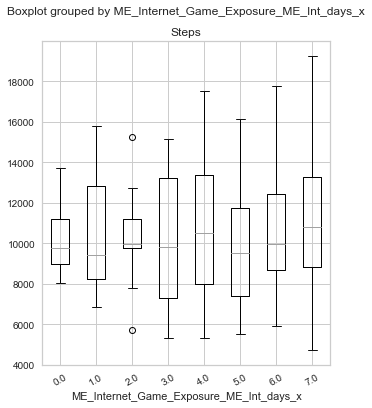

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


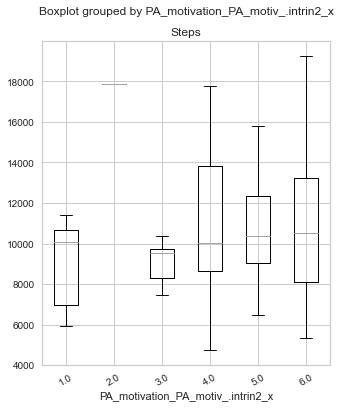

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


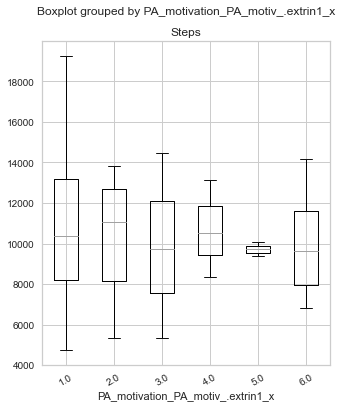

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


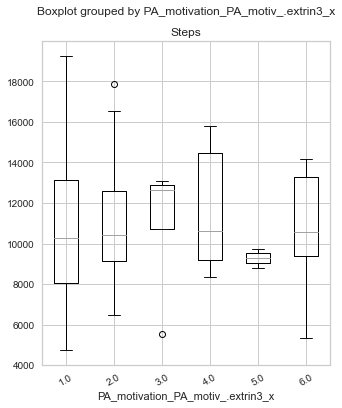

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


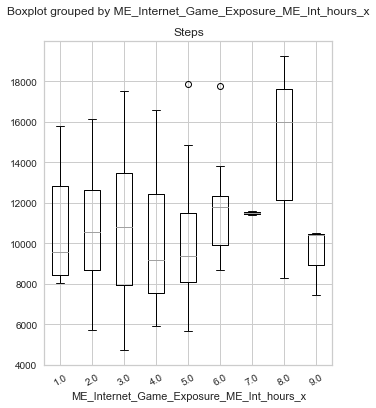

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


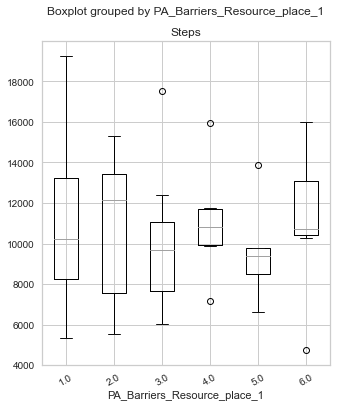

In [20]:
features = full_table_57.drop(columns = ['Steps'])
label = full_table_57['Steps']
ipynb.fs.full.script.trend_correlation_steps(features, label)

In [11]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_regression
X = full_table_57.drop(columns = ['Steps'])
y = full_table_57['Steps']

test = SelectKBest(score_func=f_regression, k=6)
fit = test.fit(X, y)
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)

# summarize selected features
print(features[0:5,:])
display(X.columns)
#X = X[['Sex', 'Age', 'Betweeness', 'Closeness', 'Eigenvector', 'Avg_Short_Path', 'Bos', 'Park', 'Speeltuin', 'Sportclub']]
X.corr()

[21.41  18.778 20.456  7.298  0.12   1.892  0.138  1.197  3.293  0.544
  0.128  7.298  6.266  3.433  0.     5.231  0.037  2.113  7.57   0.068
  2.78   0.128  1.889  0.698  0.993  0.417  0.671  0.071  0.638  0.269
  0.086]
[[1428.   26.   74.    1.   89.    0.]
 [1429.   26.   74.    1.   89.    1.]
 [1605.   29.   81.    1.  483.    0.]
 [1606.   29.   81.    1.  483.    1.]
 [1608.   29.   81.    1.  483.    1.]]


Index(['Child', 'School', 'Class', 'Sex', 'Age', 'Betweeness', 'Closeness', 'Degree', 'Eigenvector', 'Avg_Short_Path', 'Density', 'Edges', 'Nodes', 'Bos', 'Park', 'Speelplein', 'Speeltuin',
       'Sportschool', 'Sportclub', 'Zwembad', 'Meer_zee', 'Dansschool', 'Sporthal', 'Grasveld', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x',
       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1'],
      dtype='object')

,Child,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
Child,1.000000,0.985243,0.996121,0.020234,-0.053877,0.050502,0.025849,0.123109,0.144382,-0.103844,0.159107,-0.544046,-0.530485,0.177630,0.102933,0.163373,0.081663,0.004622,-0.019538,-0.058760,-0.227434,-0.090092,-0.014914,-0.088035,0.090901,-0.019815,-0.067689,-0.033750,0.042859,0.020901,-0.140250
School,0.985243,1.000000,0.992649,0.018220,-0.030670,0.053210,-0.011749,0.107845,0.145992,-0.136049,0.144278,-0.579754,-0.576908,0.153132,0.117502,0.142731,0.072452,-0.015869,-0.039160,-0.078122,-0.236387,-0.117946,-0.031487,-0.097305,0.083991,-0.001000,-0.053896,-0.028686,0.035279,0.004135,-0.118872
Class,0.996121,0.992649,1.000000,0.025751,-0.045020,0.035129,0.036345,0.129432,0.146278,-0.126756,0.181276,-0.531605,-0.533608,0.159301,0.104613,0.155021,0.075997,-0.003444,-0.026401,-0.068931,-0.226404,-0.093203,-0.023050,-0.082147,0.082450,-0.002431,-0.077370,-0.038776,0.043370,0.006345,-0.140770
Sex,0.020234,0.018220,0.025751,1.000000,-0.002204,-0.118849,0.147266,0.094135,0.223574,-0.139966,0.024270,-0.025909,-0.040608,0.056313,0.079760,-0.017991,0.048606,0.071580,-0.062437,-0.078214,0.004329,0.226777,0.004943,-0.100620,0.077129,0.229273,-0.067019,-0.257258,0.116029,-0.268220,-0.183655
Age,-0.053877,-0.030670,-0.045020,-0.002204,1.000000,0.061651,-0.040056,-0.004178,0.057477,-0.086983,-0.025363,-0.065638,-0.091620,-0.029284,-0.140693,-0.119272,-0.202452,0.043434,0.058615,0.126983,0.064381,-0.120775,0.033276,-0.070318,0.091973,0.003118,0.123555,0.245980,-0.038492,-0.015343,0.055059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA_motivation_PA_motiv_.extrin1_x,-0.067689,-0.053896,-0.077370,-0.067019,0.123555,0.078408,-0.078598,0.027601,0.025749,-0.068337,-0.048190,-0.129879,-0.111187,0.011912,0.060425,0.021886,0.081652,0.059507,0.103692,0.125492,-0.086922,-0.030326,0.157774,0.093934,0.024993,0.164527,1.000000,0.512114,0.089565,0.189054,0.089435
PA_motivation_PA_motiv_.extrin3_x,-0.033750,-0.028686,-0.038776,-0.257258,0.245980,0.031922,0.047997,0.035973,0.080957,-0.022161,0.063198,-0.064810,-0.096050,-0.048293,-0.014151,-0.038915,-0.029553,-0.107216,-0.082249,0.011008,-0.066087,-0.157160,-0.035712,0.049859,-0.026450,0.025543,0.512114,1.000000,0.015106,0.059498,0.147326
PA_motivation_PA_motiv_.intrin3_x,0.042859,0.035279,0.043370,0.116029,-0.038492,0.068106,0.057673,0.126863,0.049255,-0.041477,0.044256,0.000927,-0.021988,-0.073841,0.009893,-0.027158,-0.072141,-0.024475,0.042504,0.010417,-0.029283,-0.035412,-0.091637,-0.016265,0.069980,0.573367,0.089565,0.015106,1.000000,-0.080300,-0.016329
ME_Internet_Game_Exposure_ME_Int_hours_x,0.020901,0.004135,0.006345,-0.268220,-0.015343,-0.052968,0.023885,-0.028994,0.005584,0.097672,-0.003487,-0.030379,0.003928,0.062373,-0.034804,-0.027689,0.023808,0.005541,-0.033785,0.161628,-0.007032,-0.009528,0.066245,-0.096522,0.321434,-0.081988,0.189054,0.059498,-0.080300,1.000000,0.148727


range(0, 31)

Fitting linear regression

R^2: 0.31418879808829947 

Coefficients
-------------------------------------
Intercept: 22867.075491555017
Child: 0.31640306081894665
School: -847.6671444862714
Class: 205.24880354342582
Sex: -1726.3681175337422
Age: -97.21564514269596
Betweeness: -4600.533431478873
Closeness: 2227.053657387327
Degree: 256.3656509522385
Eigenvector: 2459.485695691163
Avg_Short_Path: 896.3873110199822
Density: -8773.842239482052
Edges: 8.307469374248576
Nodes: -324.6994828801838
Bos: 440.3245907025195
Park: -12.487577102041882
Speelplein: 516.6404181655867
Speeltuin: -88.22397773980599
Sportschool: 196.3915774869028
Sportclub: 1346.6532931527336
Zwembad: -670.7048515753964
Meer_zee: -1118.9922966267459
Dansschool: -560.1887572484687
Sporthal: 434.9031524074974
Grasveld: 272.79762108799054
ME_Internet_Game_Exposure_ME_Int_days_x: 145.2305202120421
PA_motivation_PA_motiv_.intrin2_x: 308.04083133351804
PA_motivation_PA_motiv_.extrin1_x: -319.18306607140215
PA_motivation_PA_motiv

C:\Users\Armin\anaconda3\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


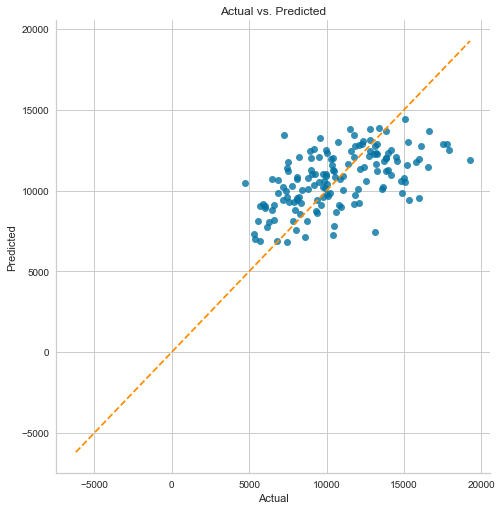

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.022277387860110368
Residuals are not normally distributed


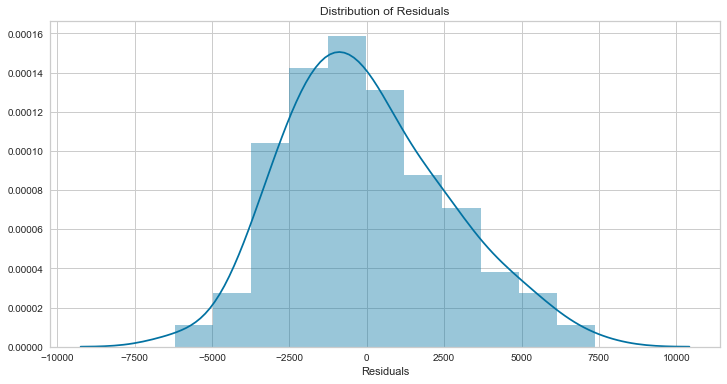


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


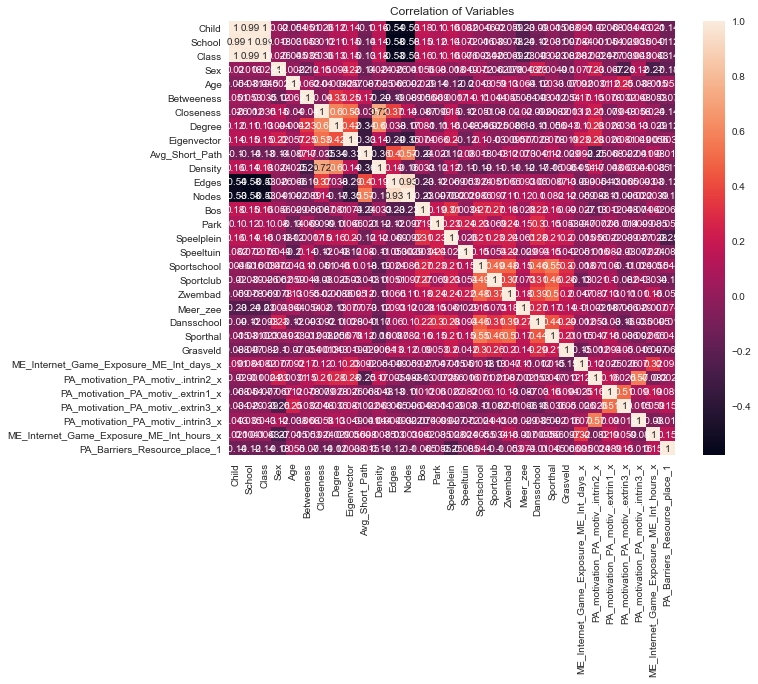

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Child: 5793.373579231959
School: 7596.9859525545335
Class: 19040.372244529088
Sex: 4.194890176245916
Age: 308.807898865892
Betweeness: 5.377269452056362
Closeness: 731.628875135498
Degree: 58.57703838190768
Eigenvector: 122.44419198762917
Avg_Short_Path: 222.68932990691013
Density: 437.2733203689804
Edges: 359.38095592944177
Nodes: 860.1165537984759
Bos: 2.003732406433848
Park: 2.5958953566258103
Speelplein: 4.064411693350085
Speeltuin: 7.758708957299438
Sportschool: 3.1516767520689664
Sportclub: 3.202287602775103
Zwembad: 2.890939055866565
Meer_zee: 1.6110377698617224
Dansschool: 2.62562123457861
Sporthal: 3.2589530446446595
Grasveld: 6.876520492818622
ME_Internet_Game_Exposure_ME_Int_days_x: 8.462080969516215
PA_motivation_PA_motiv_.intrin2_x: 41.36364564948974
PA_motivation_PA_motiv_.extrin1_x: 4.1436760

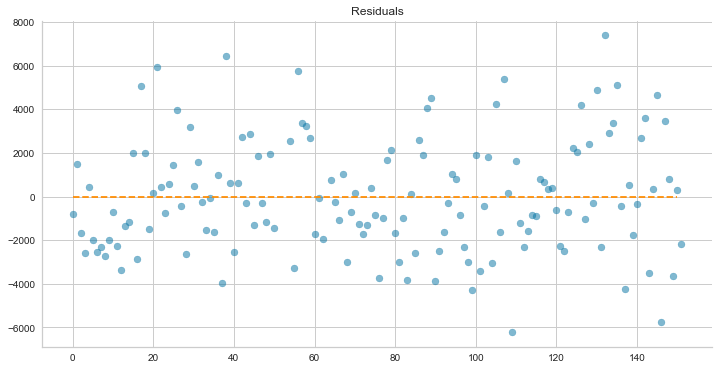

If heteroscedasticity is apparent, confidence intervals and predictions will be affected


In [12]:
ipynb.fs.full.script.linear_regression_assumptions(X, y, X.columns)

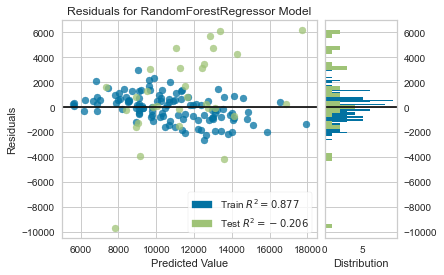

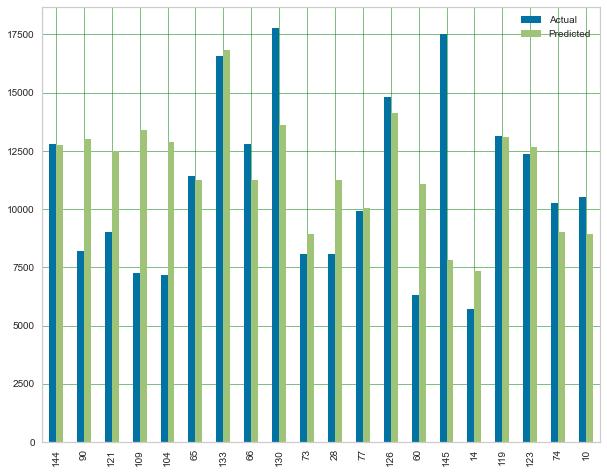

In [13]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 69)

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

visualizer = ResidualsPlot(rf)
visualizer.fit(features_train, label_train)  # Fit the training data to the visualizer
visualizer.score(features_test, label_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

predictions = visualizer.predict(features_test)
df = pd.DataFrame({'Actual': label_test, 'Predicted': predictions})
df1 = df.head(20)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [14]:
#check if 0 is male or female
full_table_57['Steps_class'] = pd.qcut(full_table_57['Steps'], q=4, labels=['1', '2', '3', '4'])
temp = full_table_57[['Sex', 'Steps']]

temp.loc[(temp['Steps'] < 10000), 'Steps_class'] = 0
temp.loc[(temp['Steps'] > 11700), 'Steps_class'] = 2
temp.loc[(temp['Steps'] > 10000) & (temp['Steps'] < 11700), 'Steps_class'] = 1

full_table_57['Steps_class'] = temp['Steps_class']
temp['Steps_class'].value_counts()


C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.0    68
2.0    57
1.0    23
Name: Steps_class, dtype: int64

[0.579 0.    0.455]
[0.733 0.    0.5  ]


C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.647, 0.   , 0.476])

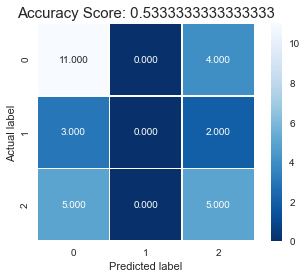

In [16]:
features = full_table_57.drop(columns = ['Steps','Steps_class'])
label = full_table_57['Steps_class']

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

rfc = RandomForestClassifier()
rfc.fit(features_train, label_train)
predictions = rfc.predict(features_test)
score = rfc.score(features_test, label_test)
prec_score = precision_score(label_test, predictions, average = None)
rec_score = recall_score(label_test, predictions, average = None)
f1 = f1_score(label_test, predictions, average = None)

s=confusion_matrix(label_test, predictions)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
print(prec_score)
print(rec_score)
f1

In [17]:
cv = KFold(n_splits=4, random_state=1, shuffle=True)
scores = cross_val_score(rfc, features, label, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.514 (0.033)


In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features_train, label_train)
rf_random.best_params_



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

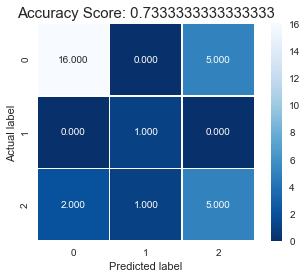

Model Performance
0.7333333333333333
[0.889 0.5   0.5  ]
[0.762 1.    0.625]
[0.821 0.667 0.556]


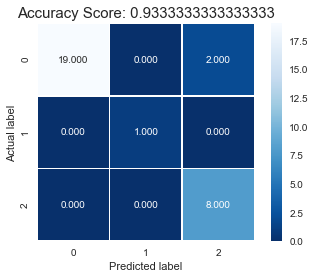

Model Performance
0.9333333333333333
[1.  1.  0.8]
[0.905 1.    1.   ]
[0.95  1.    0.889]


In [19]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = model.score(test_features, test_labels)
    prec_score = precision_score(label_test, predictions, average = None)
    rec_score = recall_score(label_test, predictions, average = None)
    f1 = f1_score(label_test, predictions, average = None)
    s=confusion_matrix(label_test, predictions)
    sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
    plt.title(all_sample_title, size = 15);
    plt.show()
    print('Model Performance')
    print(accuracy)
    print(prec_score)
    print(rec_score)
    print(f1)
    return

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)
 
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(features_train, label_train)
evaluate(base_model, features_test, label_test)

best_random = rf_random.best_estimator_
evaluate(best_random, features_test, label_test)
